# AMICI Quick Start Tutorial


AMICI is an interpretable attention framework that can be applied to single-cell spatial transcriptomics data that jointly estimates interaction length scales, adaptively resolves sender-receiver subpopulations, and links communication to downstream gene programs.

In [1]:
import warnings; warnings.filterwarnings("ignore") # remove scanpy warnings for the tutorial.

In [2]:
# !pip install -q amici-st

In [3]:
import os
import torch
import scanpy as sc
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import matplotlib.pyplot as plt

from amici import AMICI
from amici.callbacks import AttentionPenaltyMonitor
from amici.interpretation import (
    AMICICounterfactualAttentionModule,
    AMICIAttentionModule,
    AMICIAblationModule,
)

## Load the and split the data
Load the AnnData located at ______________. Perform any filtering of cells but retain the raw counts. Split the dataset into a train and test set -- we generally do a train-test split of 90%-10%.

In [5]:
# Load data
adata_path = "./data/mouse_cortex_tutorial.h5ad"
adata = sc.read(adata_path, backup_url="https://figshare.com/ndownloader/files/58303438")

# Saving the spatial coordinates in the adata.obsm["spatial"] key
adata.obsm["spatial"] = adata.obs[["centroid_x", "centroid_y"]].values

adata_train = adata[adata.obs['in_test'] == False].copy()
adata_test = adata[adata.obs['in_test'] == True].copy()

print("Train set size: ", adata_train.shape)
print("Test set size: ", adata_test.shape)

# Create the cell type palette
labels_key = "subclass"
CELL_TYPE_PALETTE = {
    # Excitatory Neurons
    "L2/3 IT": "#e41a1c",
    "L4/5 IT": "#ff7f00",
    "L5 IT": "#fdbf6f",
    "L5 ET": "#e31a1c",
    "L6 IT": "#6a3d9a",
    "L6 IT Car3": "#cab2d6",
    "L6 CT": "#fb9a99",
    "L5/6 NP": "#a6cee3",
    "L6b": "#1f78b4",
    # Inhibitory Neurons
    "Pvalb": "#8dd3c7",
    "Sst": "#80b1d3",
    "Lamp5": "#33a02c",
    "Vip": "#b2df8a",
    "Sncg": "#bc80bd",
    # Glial Cells
    "Astro": "#bebada",
    "Oligo": "#fb8072",
    "OPC": "#b3de69",
    "Micro": "#fccde5",
    "VLMC": "#d9d9d9",
    # Vascular Cells
    "Endo": "#ffff33",
    "Peri": "#ffffb3",
    "PVM": "#fdb462",
    "SMC": "#8dd3c7",
    # Other
    "other": "#999999",
}

Train set size:  (27567, 254)
Test set size:  (6264, 254)


Visualize the spatial distribution and the train-test split of the dataset

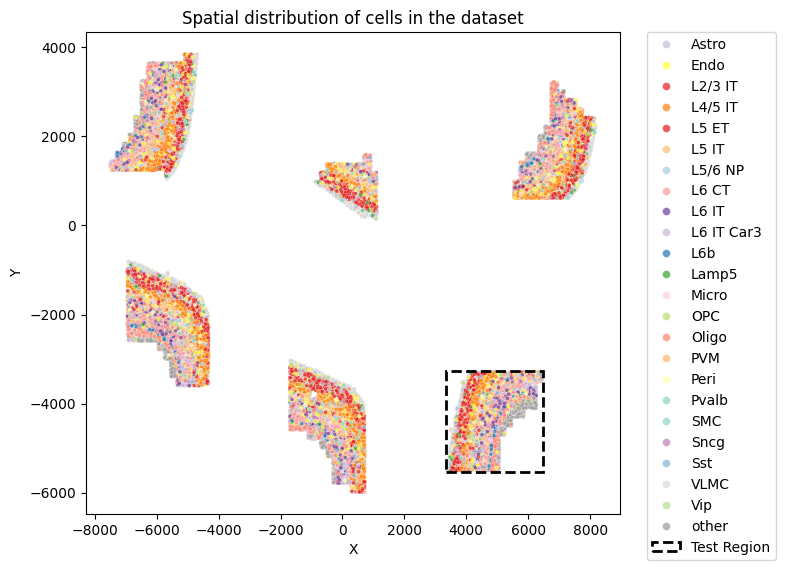

In [6]:
def visualize_spatial_distribution(adata, labels_key="subclass", x_lim=None, y_lim=None):
    plot_df = pd.DataFrame(adata.obsm["spatial"].copy(), columns=["X", "Y"])
    plot_df[labels_key] = adata.obs[labels_key].values
    plot_df["in_test"] = adata.obs["in_test"].values
    plot_df["slice_id"] = adata.obs["slice_id"].values

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        plot_df, x="X", y="Y", hue=labels_key, alpha=0.7, s=8, palette=CELL_TYPE_PALETTE
    )

    test_df = plot_df[plot_df["in_test"] == True]
    if len(test_df) > 0:
        min_x, max_x = test_df["X"].min(), test_df["X"].max()
        min_y, max_y = test_df["Y"].min(), test_df["Y"].max()
        width = max_x - min_x
        height = max_y - min_y

        padding = 20
        rect = plt.Rectangle(
            (min_x - padding, min_y - padding),
            width + 2*padding,
            height + 2*padding,
        fill=False,
        color='black',
        linestyle='--',
        linewidth=2,
        label=f'Test Region'
    )
    plt.gca().add_patch(rect)

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(f"Spatial distribution of cells in the dataset")

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(
        handles=handles,
        labels=labels,
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        borderaxespad=0.0,
        markerscale=2
    )

    if x_lim is not None:
        plt.xlim(0, x_lim)
    if y_lim is not None:
        plt.ylim(0, y_lim)
    plt.tight_layout()
    plt.show()

visualize_spatial_distribution(adata)

## Setup and train AMICI
Setup the hyperparameters for training AMICI. For your custom dataset, we suggest performing a sweep over a small range of values for the following hyperparameters:
- `end_attention_penalty`
- `epoch_start` and `epoch_end`
- `value_l1_penalty_coef`

In [7]:
# Set up the seed for reproducibility
seed = 18
pl.seed_everything(seed)

penalty_schedule_params = {
    "start_attention_penalty": 1e-6,
    "end_attention_penalty": 1e-3,
    "epoch_start": 10,
    "epoch_end": 30,
    "flavor": "linear",
}

log_params = {
    "use_wandb": False,
}
model_params = {
    "n_heads": 8,
    "n_query_dim": 128,
    "n_head_size": 32,
    "n_nn_embed": 256,
    "n_nn_embed_hidden": 512,
    "attention_dummy_score": 3.0,
    "neighbor_dropout": 0.1,
    "attention_penalty_coef": penalty_schedule_params[
        "start_attention_penalty"
    ],
    "value_l1_penalty_coef": 1e-5,
}
exp_params = {
    "lr": 1e-3,
    "epochs": 400,
    "batch_size": 512,
    "early_stopping": True,
    "early_stopping_monitor": "elbo_validation",
    "early_stopping_patience": 20,
    "learning_rate_monitor": True,
    "n_neighbors": 50,
}

Seed set to 18


Define the model and setup the AnnData with the model parameters.

In [8]:
AMICI.setup_anndata(
    adata_train,
    labels_key=labels_key,
    coord_obsm_key="spatial",
    n_neighbors=exp_params["n_neighbors"],
)
model = AMICI(adata_train, **model_params)

INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


In [9]:
model_path = os.path.join(
    "./saved_models",
    f"cortex_{seed}_params",
)

plan_kwargs = {}
if "lr" in exp_params:
    plan_kwargs["lr"] = exp_params["lr"]

Train the model using the above defined parameters.

In [10]:
model.train(
    max_epochs=int(exp_params.get("epochs")),
    batch_size=int(exp_params.get("batch_size", 128)),
    plan_kwargs=plan_kwargs,
    early_stopping=exp_params.get("early_stopping", False),
    early_stopping_monitor=exp_params.get("early_stopping_monitor"),
    early_stopping_patience=exp_params.get("early_stopping_patience", 5),
    check_val_every_n_epoch=1,
    use_wandb=log_params.get("use_wandb"),
    callbacks=[
        AttentionPenaltyMonitor(
            penalty_schedule_params["epoch_start"],
            penalty_schedule_params["epoch_end"],
            penalty_schedule_params["start_attention_penalty"],
            penalty_schedule_params["end_attention_penalty"],
            penalty_schedule_params["flavor"],
        ),
    ],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 35/400:   9%|▉         | 35/400 [05:03<52:41,  8.66s/it, v_num=1, train_loss_step=53.5, train_loss_epoch=56.6]
Monitored metric elbo_validation did not improve in the last 20 records. Best score: 58.693. Signaling Trainer to stop.


In [11]:
model.save(model_path, overwrite=True)

Evaluate on the test set. It's important to include all the data when setting up the AnnData to ensure that neighbors that would not have been included in the test set are included.

In [12]:
AMICI.setup_anndata(
    adata,
    labels_key=labels_key,
    coord_obsm_key="spatial",
    n_neighbors=exp_params["n_neighbors"],
)

# Get test set metrics
test_elbo = model.get_elbo(
    adata, indices=np.where(adata.obs["in_test"])[0], batch_size=128
).item()
test_reconstruction_loss = model.get_reconstruction_error(
    adata, indices=np.where(adata.obs["in_test"])[0], batch_size=128
)["reconstruction_loss"]

print(f"Test ELBO: {test_elbo}")
print(f"Test Reconstruction Loss: {test_reconstruction_loss}")


INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
Test ELBO: -60.04674530029297
Test Reconstruction Loss: 60.04281234741211


## AMICI's downstream interpretation

Load the model if not already saved and setup the AnnData. 

In [13]:
model = AMICI.load(
    model_path,
    adata=adata,
)
AMICI.setup_anndata(
    adata,
    labels_key=labels_key,
    coord_obsm_key="spatial",
    n_neighbors=exp_params["n_neighbors"],
)

INFO     File ./saved_models/cortex_18_params/model.pt already downloaded                                          
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


### High-level interaction scores

In [41]:
ablation_residuals_path = "./data/cortex_ablation_residuals.pkl"
if os.path.exists(ablation_residuals_path):
    ablation_residuals = AMICIAblationModule.load_object(ablation_residuals_path)
else:
    ablation_residuals = model.get_neighbor_ablation_scores(
        adata=adata,
        compute_z_value=True,
    )
    ablation_residuals.save_object(ablation_residuals_path) 

Plot the high-level interaction map showing all interactions between cell types. We generally filter by a weight threshold to filter out interactions with relatively low interaction strengths.

0.86 quantile threshold: 28.00


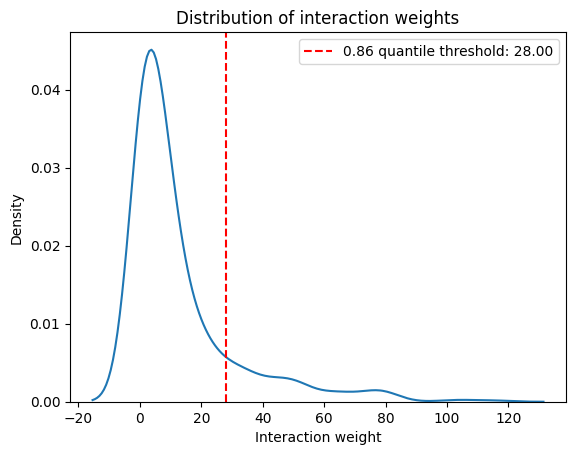

In [44]:
interaction_weight_matrix_df = ablation_residuals._get_interaction_weight_matrix()
interaction_weight_matrix = interaction_weight_matrix_df.values.flatten()
quantile = 0.86
weight_threshold = np.quantile(interaction_weight_matrix, quantile)
print(f"{quantile} quantile threshold: {weight_threshold:.2f}")

sns.kdeplot(
    x=interaction_weight_matrix
)
plt.title("Distribution of interaction weights")
plt.xlabel("Interaction weight")
plt.ylabel("Density")
plt.axvline(weight_threshold, color='r', linestyle='--', label=f'{quantile} quantile threshold: {weight_threshold:.2f}')
plt.legend()
plt.show()

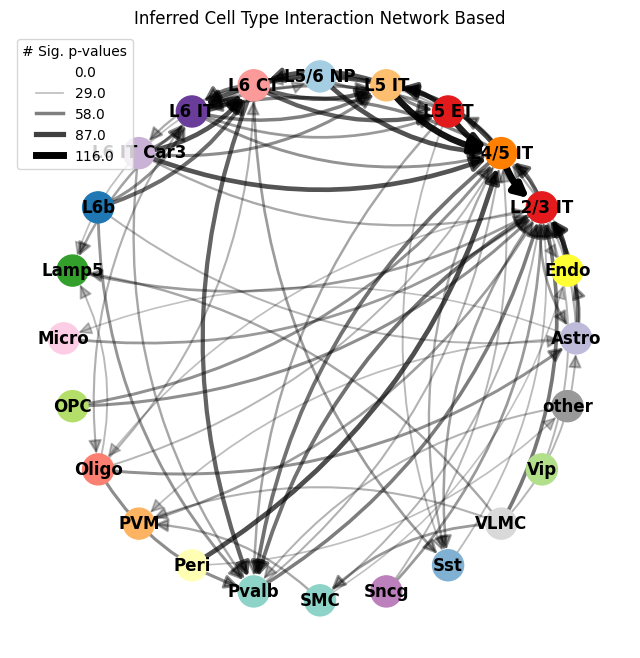

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [45]:
ablation_residuals.plot_interaction_directed_graph(
    significance_threshold=0.05,
    weight_threshold=weight_threshold,
    node_size=500,
    palette=CELL_TYPE_PALETTE,
)

### Per-gene ablation scores

For a specific receiver of interest, for example Astrocytes, we can plot the ablation scores as a dotplot ranked by an arbitrary number of top genes.

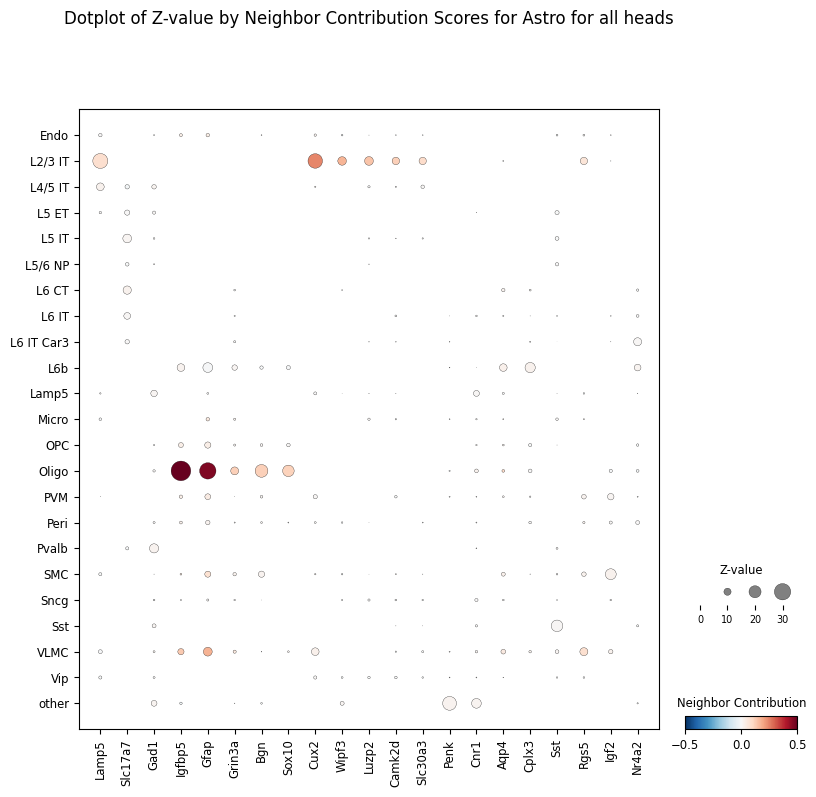

In [19]:
target_ct = "Astro"

ablation_residuals.plot_featurewise_contributions_dotplot(
    cell_type=target_ct,
    color_by="diff",
    size_by="z_value",
    min_size_by=10,
    step=10,
    n_top_genes=5,
)

### Counterfactual attention scores

In [20]:
counterfactual_attention_patterns = model.get_counterfactual_attention_patterns(
    cell_type=target_ct,
    adata=adata,
)

We can visualize the length scales for different pairs of interactions between the target cell type and other senders

<Figure size 1200x600 with 0 Axes>

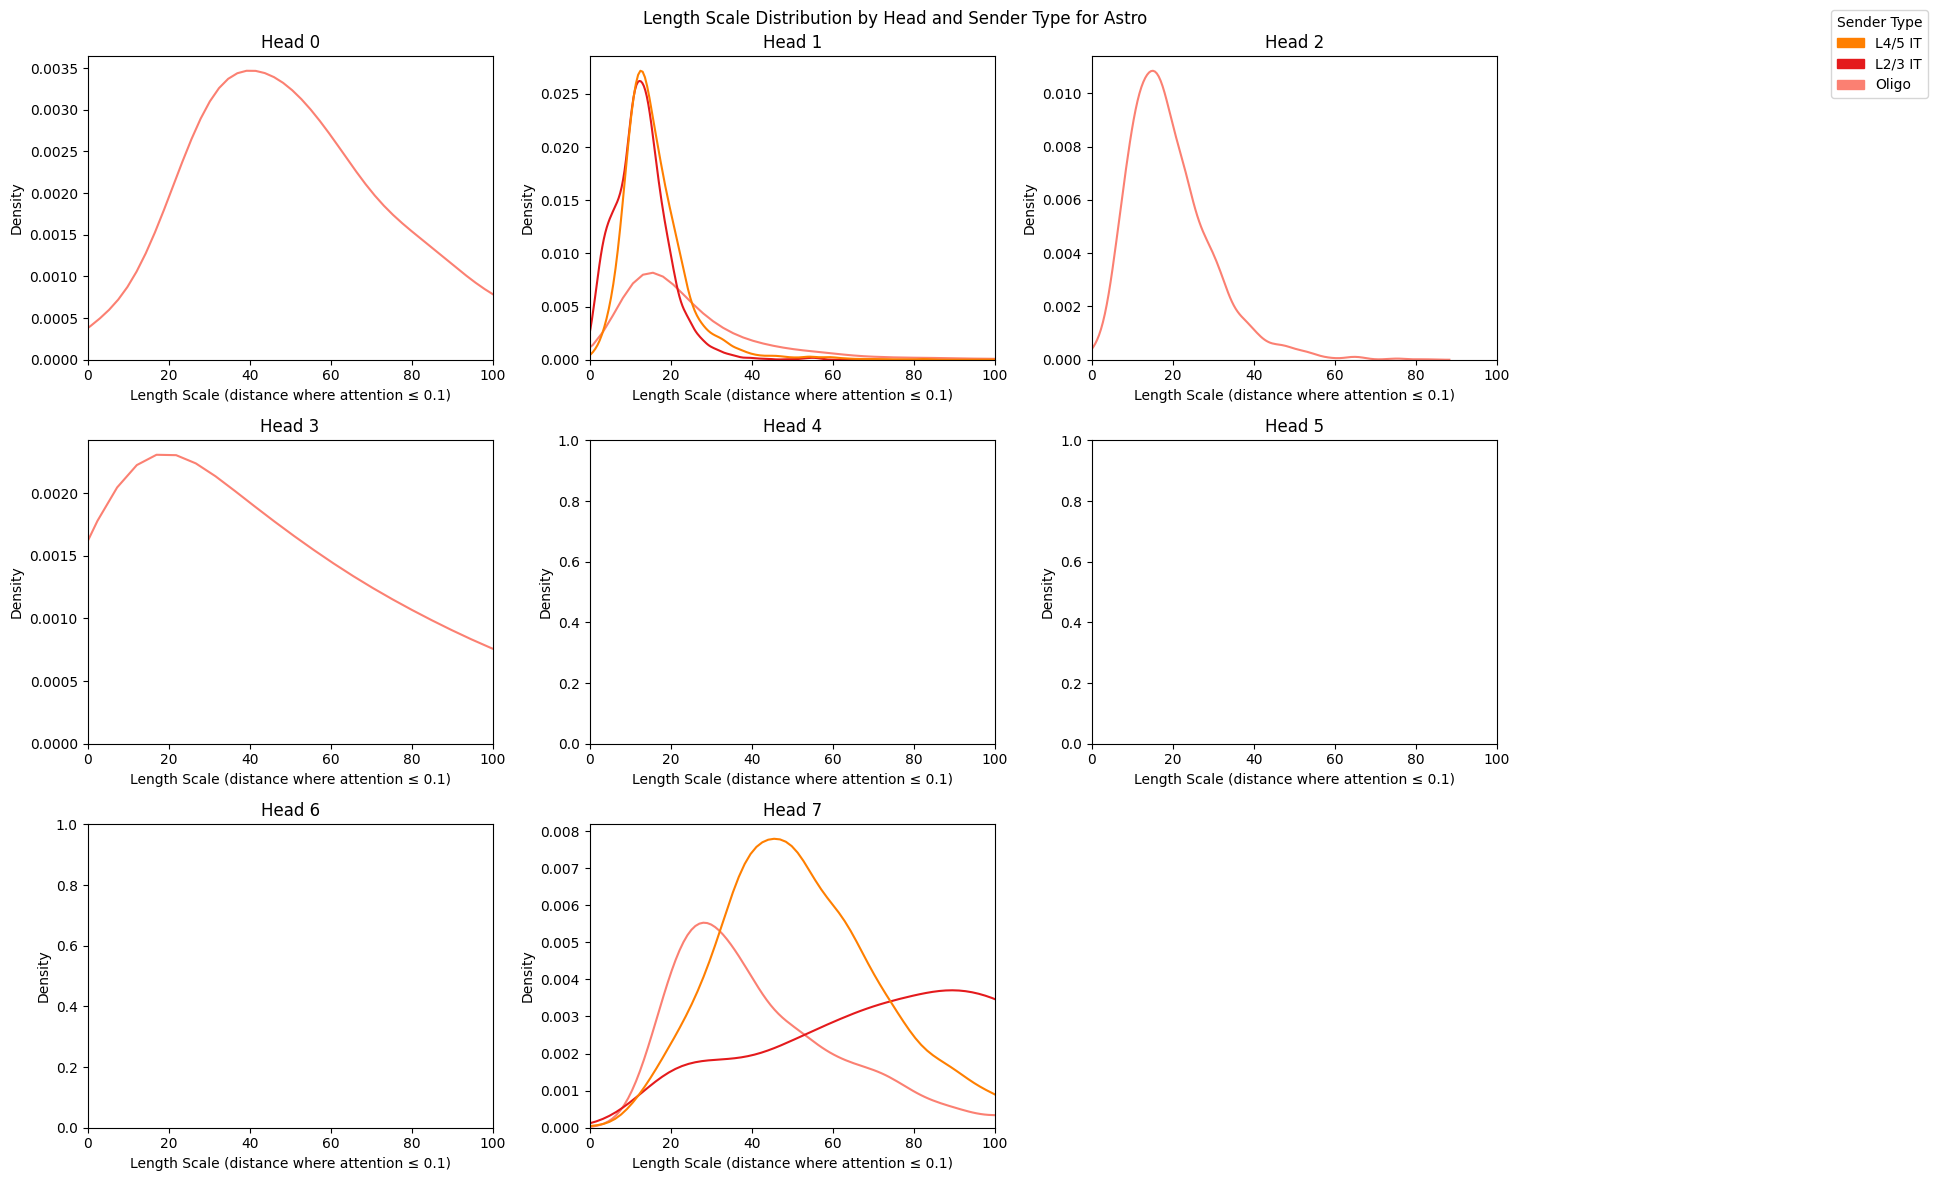

In [35]:
sender_types = ["L4/5 IT", "L2/3 IT", "Oligo"]

length_scale_df = counterfactual_attention_patterns.plot_length_scale_distribution(
    head_idxs=range(model.module.n_heads),
    sender_types=sender_types,
    attention_threshold=0.1,
    plot_kde=True,
    sample_threshold=0.02,
    max_length_scale=100,
    palette=CELL_TYPE_PALETTE
)

By default we plot the ablation scores across all heads but we can also visualize mediating genes learned by a specific head, corresponding to different length scales learned across attention heads.

In [40]:
ablation_residuals_sub = model.get_neighbor_ablation_scores(
    adata=adata,
    ablated_neighbor_ct_sub=["L4/5 IT", "L2/3 IT", "Oligo"],
    compute_z_value=True,
    head_idx=1,
)

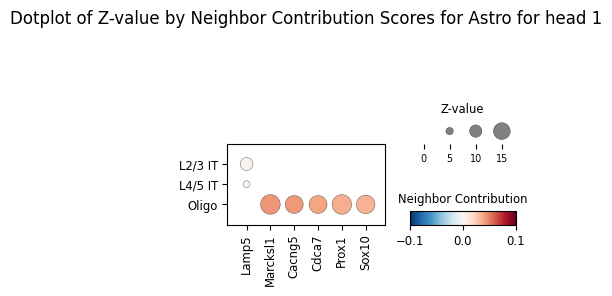

In [46]:
ablation_residuals_sub.plot_featurewise_contributions_dotplot(
    cell_type=target_ct,
    color_by="diff",
    size_by="z_value",
    min_size_by=10,
    step=5,
    n_top_genes=5,
    vrange=0.1,
)

### Empirical attention scores

In [56]:
cell_type_sub = ["L2/3 IT", "Oligo", "Astro"]
attention_patterns = model.get_attention_patterns(
    adata,
    batch_size=32,
)

100%|██████████| 1058/1058 [00:10<00:00, 98.66it/s] 


We can plot a general attention summary of the attention scores for any set of cell types of interest. The attention patterns module contains the attention scores between every cell type and it's neighborhood, which can be used to spatially visualize populations with high attention for different cells. 

Cell type: 100%|██████████| 3/3 [00:06<00:00,  2.21s/it]


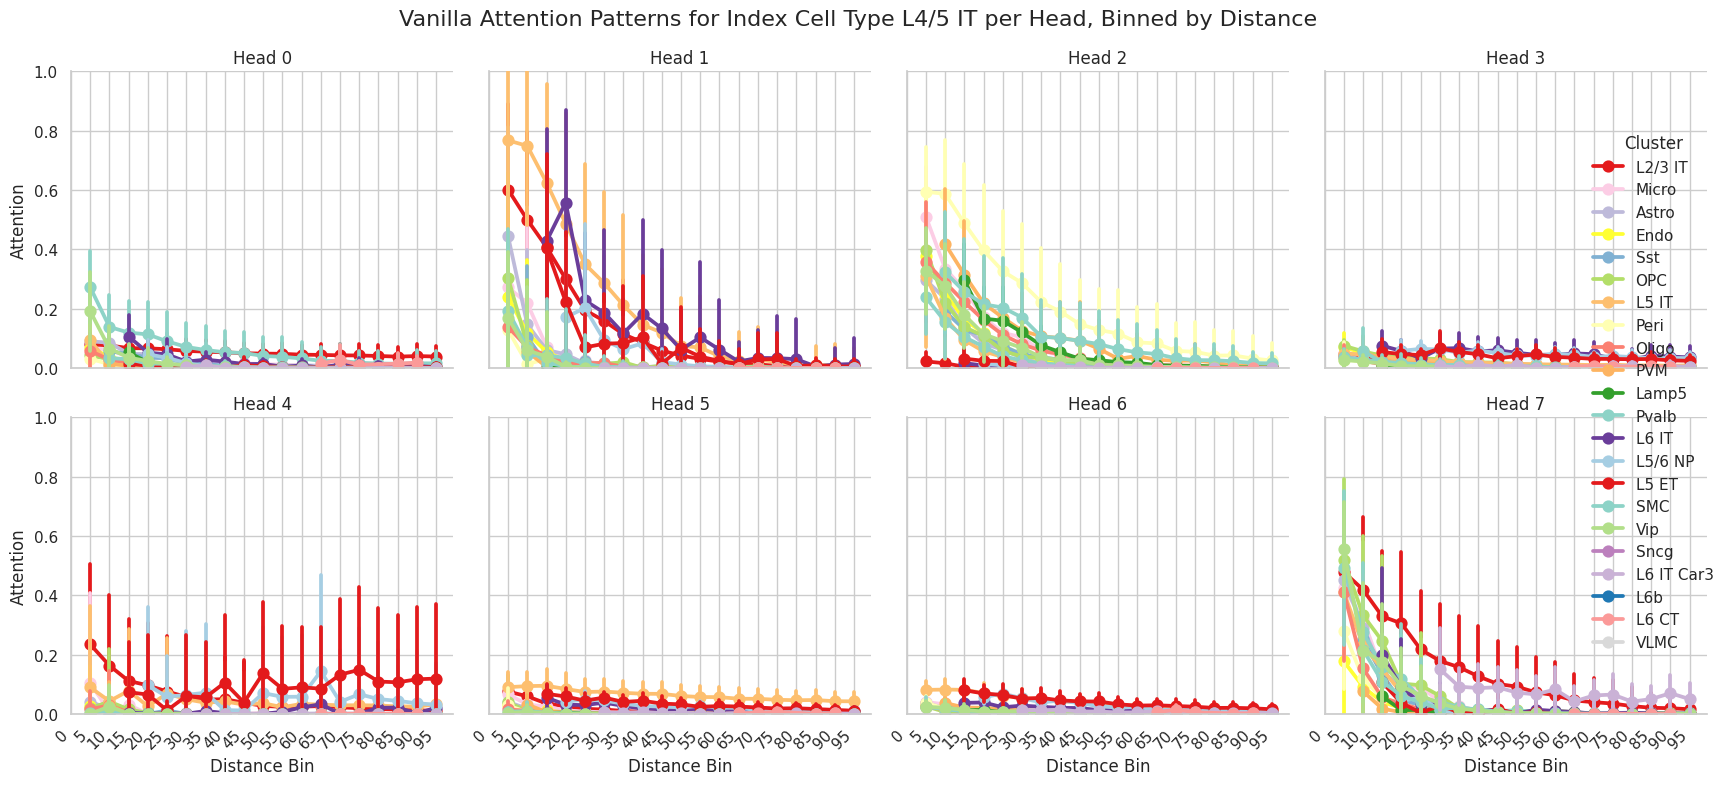

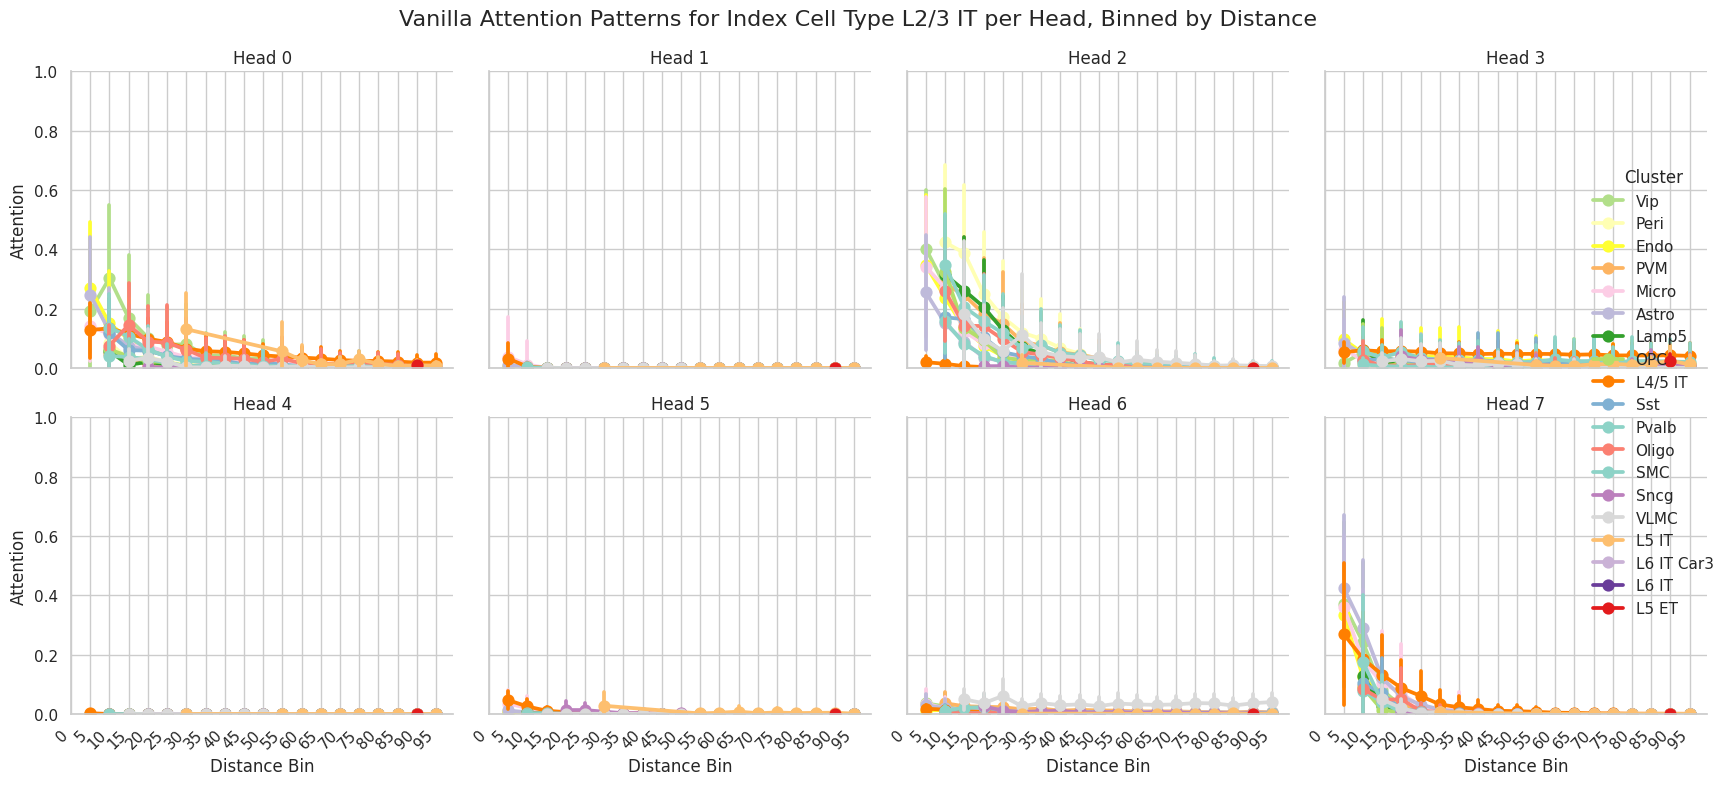

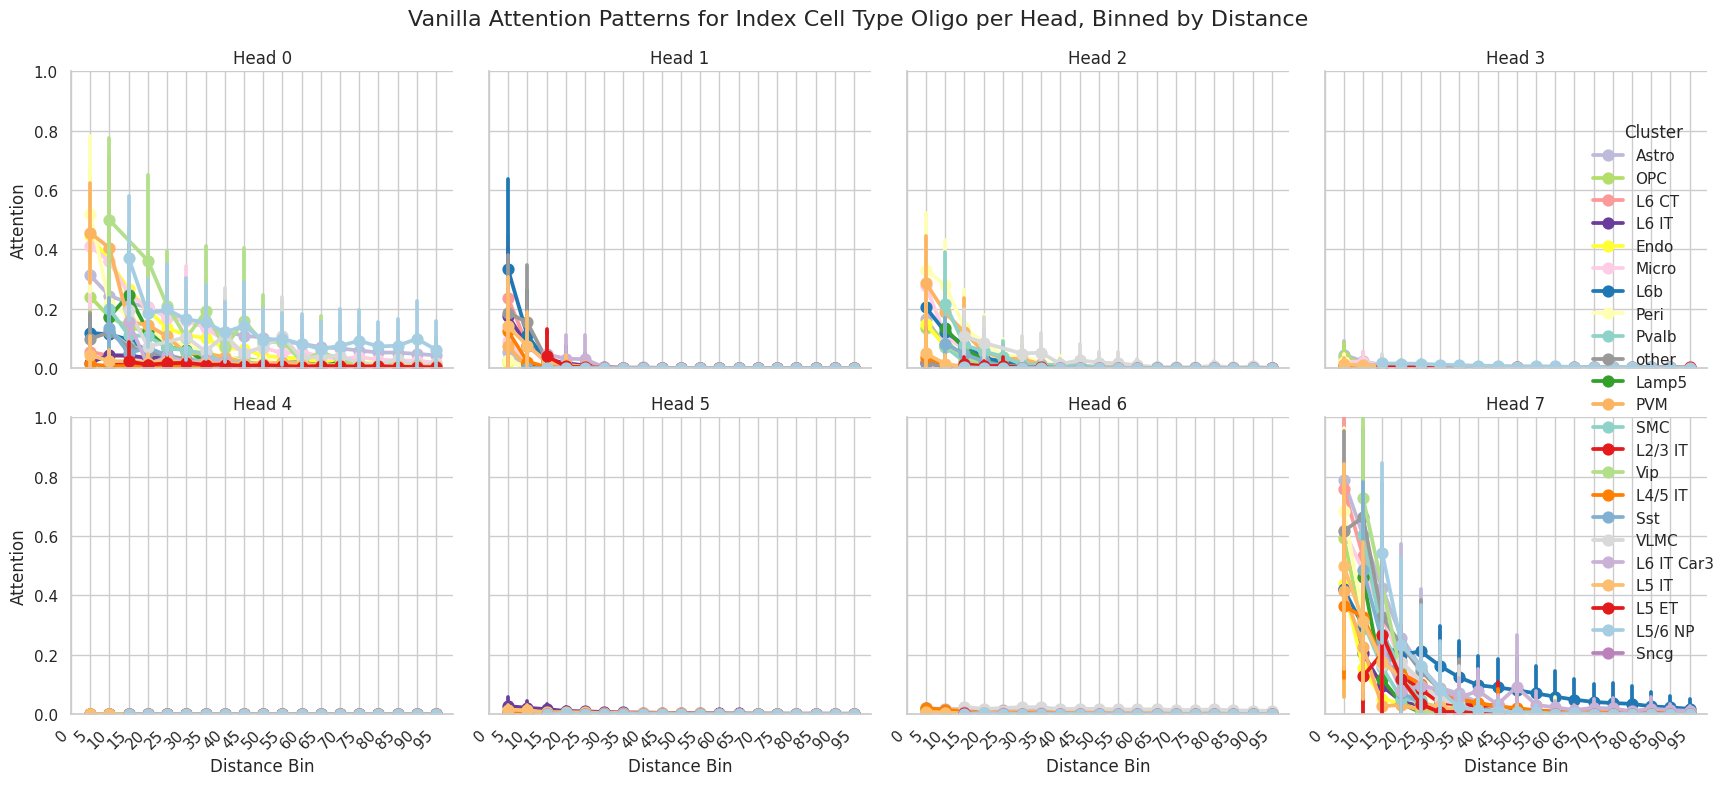

In [57]:
attention_patterns.plot_attention_summary(
    cell_type_sub=sender_types,
    palette=CELL_TYPE_PALETTE,
)